In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
class DigitDataset():
    def __init__(
        self, data_path: Path, transformse: bool = False
    ) -> None:
        super().__init__()
        self.dataset = pd.read_csv(data_path)
        self.transforms = transforms.ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset.iloc[index]
        label, data = data[0], data[1:]
        data = np.reshape(np.array(data, dtype=np.uint8), (28,28))
        data = self.transforms(data) # Transform values to be in range 0-1

        return data, label

In [3]:
def data_viz(data, label, tile: bool = False):
    if tile:
        num_samples = data.shape[0]
        plt_row = int(np.sqrt(num_samples))
        plt_col = int(np.ceil(num_samples / plt_row))
        for i in range(num_samples):
            img = data[i].squeeze()
            plt.subplot(plt_row, plt_col, i + 1)
            plt.title("Label: " + str(int(label[i])))
            plt.axis("off")
            plt.imshow(img)
        plt.tight_layout()
    else:
        img = data.squeeze()
        plt.title("Label: " + str(int(label)))
        plt.axis("off")
        plt.imshow(img)
    plt.show()

In [4]:
train_path = Path("./Dataset/train.csv")
train_dataset = DigitDataset(data_path=train_path)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

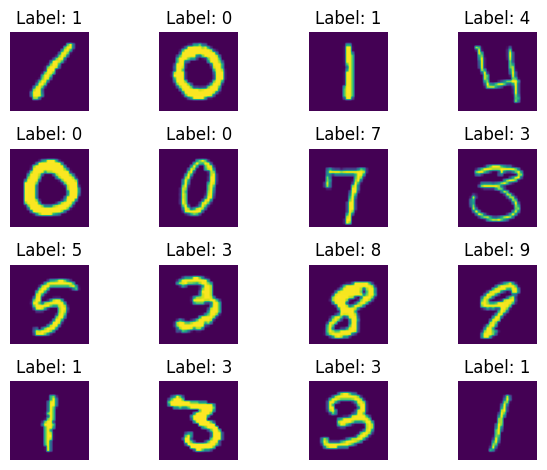

[INFO] Minimum data value: 0.0, Maximum data value: 1.0


In [5]:
images, labels = next(iter(train_loader))
data_viz(data=images, label=labels, tile=True)
print(f"[INFO] Minimum data value: {torch.min(images)}, Maximum data value: {torch.max(images)}")

In [54]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # N, 64, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid(), 
        )
    def forward(self, x):
        encoded = self.encoder(x)
        print(f"Encoded value from Autoencoder:{encoded}")
        decoded = self.decoder(encoded)
        return decoded

# Note: Data min,max [-1, 1] -> Tanh activation function
# nn.MaxPool2d -> nn.MaxUnpool2d

In [33]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # N, 64, 1, 1
        )
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Current running device: {device}")

[INFO] Current running device: cuda


In [27]:
model = Autoencoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [9]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

In [28]:
import time
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime(time.time()))
writer = SummaryWriter(log_dir=f"train_output/{current_time}")

In [29]:
%tensorboard --logdir train_output

Reusing TensorBoard on port 6006 (pid 24648), started 0:16:07 ago. (Use '!kill 24648' to kill it.)

In [30]:
num_epochs = 30
outputs = []

train_loss =0.
best_model = None
for epoch in tqdm(range(num_epochs)):
    for (img, _) in train_loader:
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    writer.add_scalar("Train Loss [epoch]", train_loss, epoch)
    tqdm.write(f"[INFO] Epoch: {epoch+1}, Loss: {loss.item():.4f}")
    outputs.append((epoch, img, recon))

    if best_model is None or train_loss < best_model:
        best_model = train_loss
        torch.save(model.state_dict(), f"train_output/{current_time}/best_model.pth")
        tqdm.write(f"[INFO] Best model saved in {epoch+1} epoch 💾")

  3%|▎         | 1/30 [00:16<07:57, 16.47s/it]

[INFO] Epoch: 1, Loss: 0.0064
[INFO] Best model saved in 1 epoch 💾


  7%|▋         | 2/30 [00:32<07:36, 16.32s/it]

[INFO] Epoch: 2, Loss: 0.0044
[INFO] Best model saved in 2 epoch 💾


 10%|█         | 3/30 [00:48<07:18, 16.23s/it]

[INFO] Epoch: 3, Loss: 0.0039
[INFO] Best model saved in 3 epoch 💾


 13%|█▎        | 4/30 [01:04<07:01, 16.19s/it]

[INFO] Epoch: 4, Loss: 0.0035
[INFO] Best model saved in 4 epoch 💾


 17%|█▋        | 5/30 [01:21<06:45, 16.21s/it]

[INFO] Epoch: 5, Loss: 0.0034
[INFO] Best model saved in 5 epoch 💾


 20%|██        | 6/30 [01:37<06:29, 16.25s/it]

[INFO] Epoch: 6, Loss: 0.0034
[INFO] Best model saved in 6 epoch 💾


 23%|██▎       | 7/30 [01:53<06:13, 16.23s/it]

[INFO] Epoch: 7, Loss: 0.0034
[INFO] Best model saved in 7 epoch 💾


 27%|██▋       | 8/30 [02:10<05:58, 16.28s/it]

[INFO] Epoch: 8, Loss: 0.0033
[INFO] Best model saved in 8 epoch 💾


 30%|███       | 9/30 [02:25<05:39, 16.16s/it]

[INFO] Epoch: 9, Loss: 0.0033
[INFO] Best model saved in 9 epoch 💾


 33%|███▎      | 10/30 [02:41<05:21, 16.06s/it]

[INFO] Epoch: 10, Loss: 0.0032
[INFO] Best model saved in 10 epoch 💾


 37%|███▋      | 11/30 [02:57<05:03, 15.99s/it]

[INFO] Epoch: 11, Loss: 0.0032
[INFO] Best model saved in 11 epoch 💾


 40%|████      | 12/30 [03:13<04:46, 15.93s/it]

[INFO] Epoch: 12, Loss: 0.0031
[INFO] Best model saved in 12 epoch 💾


 43%|████▎     | 13/30 [03:29<04:30, 15.88s/it]

[INFO] Epoch: 13, Loss: 0.0031
[INFO] Best model saved in 13 epoch 💾


 47%|████▋     | 14/30 [03:44<04:13, 15.85s/it]

[INFO] Epoch: 14, Loss: 0.0031
[INFO] Best model saved in 14 epoch 💾


 50%|█████     | 15/30 [04:00<03:57, 15.83s/it]

[INFO] Epoch: 15, Loss: 0.0031
[INFO] Best model saved in 15 epoch 💾


 53%|█████▎    | 16/30 [04:16<03:41, 15.82s/it]

[INFO] Epoch: 16, Loss: 0.0031
[INFO] Best model saved in 16 epoch 💾


 57%|█████▋    | 17/30 [04:32<03:25, 15.81s/it]

[INFO] Epoch: 17, Loss: 0.0030
[INFO] Best model saved in 17 epoch 💾


 60%|██████    | 18/30 [04:48<03:09, 15.80s/it]

[INFO] Epoch: 18, Loss: 0.0030
[INFO] Best model saved in 18 epoch 💾


 63%|██████▎   | 19/30 [05:03<02:53, 15.80s/it]

[INFO] Epoch: 19, Loss: 0.0030
[INFO] Best model saved in 19 epoch 💾


 67%|██████▋   | 20/30 [05:19<02:38, 15.80s/it]

[INFO] Epoch: 20, Loss: 0.0030
[INFO] Best model saved in 20 epoch 💾


 70%|███████   | 21/30 [05:35<02:22, 15.81s/it]

[INFO] Epoch: 21, Loss: 0.0030
[INFO] Best model saved in 21 epoch 💾


 73%|███████▎  | 22/30 [05:51<02:06, 15.81s/it]

[INFO] Epoch: 22, Loss: 0.0030
[INFO] Best model saved in 22 epoch 💾


 77%|███████▋  | 23/30 [06:07<01:50, 15.82s/it]

[INFO] Epoch: 23, Loss: 0.0031
[INFO] Best model saved in 23 epoch 💾


 80%|████████  | 24/30 [06:23<01:35, 15.93s/it]

[INFO] Epoch: 24, Loss: 0.0030
[INFO] Best model saved in 24 epoch 💾


 83%|████████▎ | 25/30 [06:39<01:20, 16.04s/it]

[INFO] Epoch: 25, Loss: 0.0030
[INFO] Best model saved in 25 epoch 💾


 87%|████████▋ | 26/30 [06:56<01:04, 16.13s/it]

[INFO] Epoch: 26, Loss: 0.0030
[INFO] Best model saved in 26 epoch 💾


 90%|█████████ | 27/30 [07:11<00:48, 16.08s/it]

[INFO] Epoch: 27, Loss: 0.0030
[INFO] Best model saved in 27 epoch 💾


 93%|█████████▎| 28/30 [07:27<00:32, 16.04s/it]

[INFO] Epoch: 28, Loss: 0.0030
[INFO] Best model saved in 28 epoch 💾


 97%|█████████▋| 29/30 [07:43<00:15, 15.99s/it]

[INFO] Epoch: 29, Loss: 0.0031
[INFO] Best model saved in 29 epoch 💾


100%|██████████| 30/30 [07:59<00:00, 16.00s/it]

[INFO] Epoch: 30, Loss: 0.0030
[INFO] Best model saved in 30 epoch 💾


In [23]:
def plot_results(outputs, type_lin:bool=True, num_exp:int=9):
    for epoch in range(0, num_epochs, 4):
        plt.figure(figsize=(num_exp,2))
        plt.gray()
        imgs = outputs[epoch][1].cpu().detach().numpy()
        recons = outputs[epoch][2].cpu().detach().numpy()
        for i, (img, recon) in enumerate(zip(imgs, recons)):
            if i >= num_exp: break
            plt.subplot(2, num_exp, i+1)
            if type_lin : img = img.reshape(-1, 28, 28)
            plt.axis("off")
            plt.imshow(img[0])

            plt.subplot(2, num_exp, num_exp+i+1)
            if type_lin : recon = recon.reshape(-1, 28, 28)
            plt.axis("off")
            plt.imshow(recon[0])

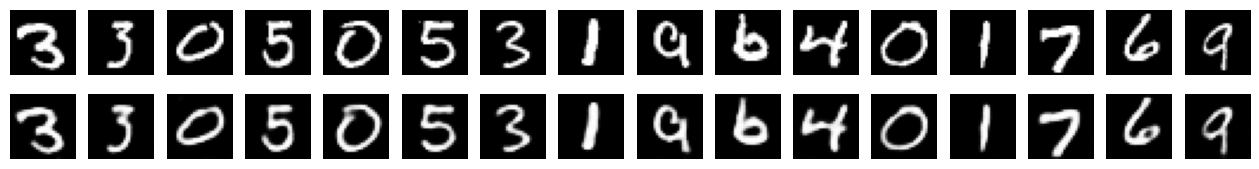

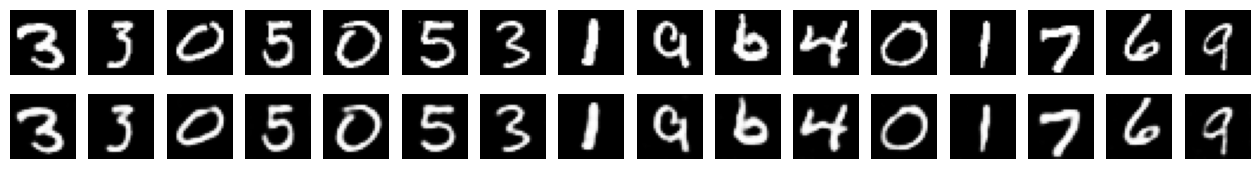

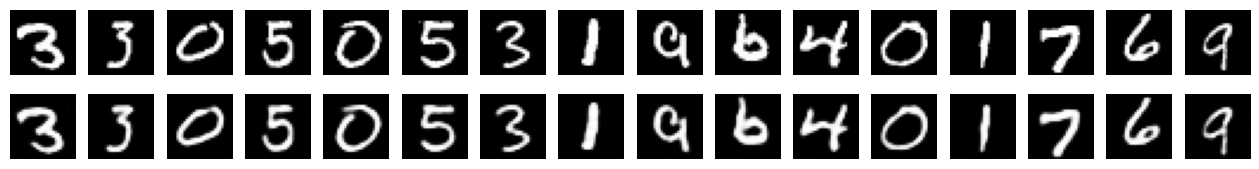

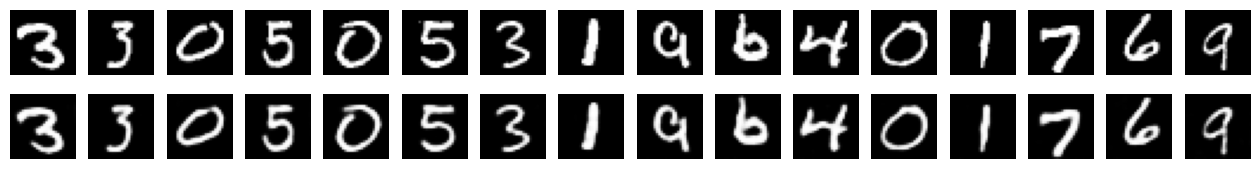

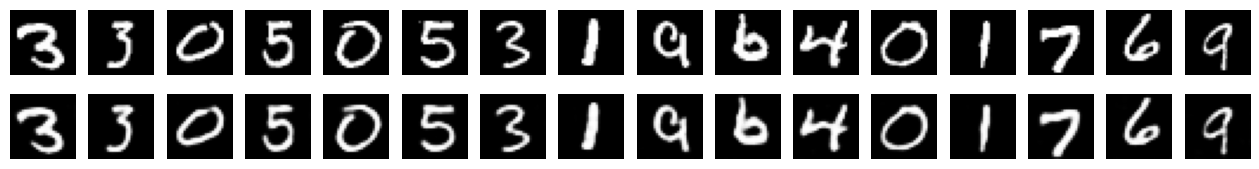

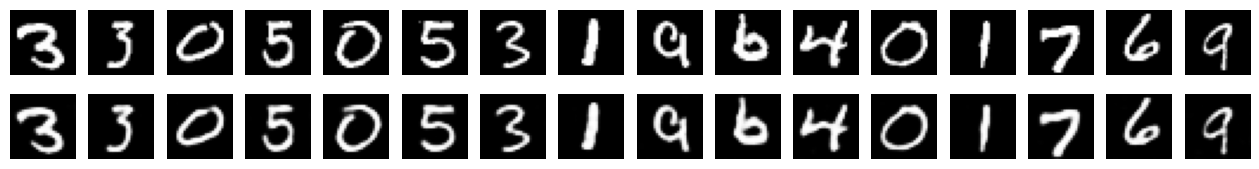

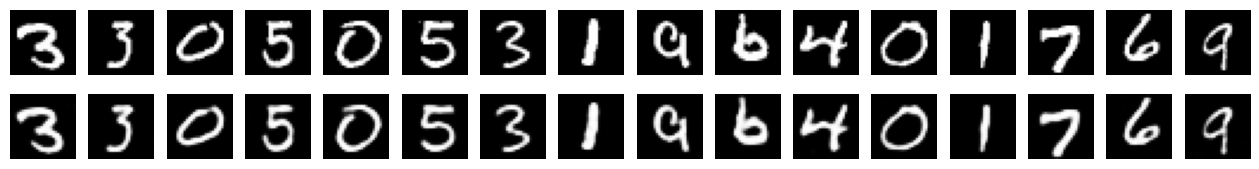

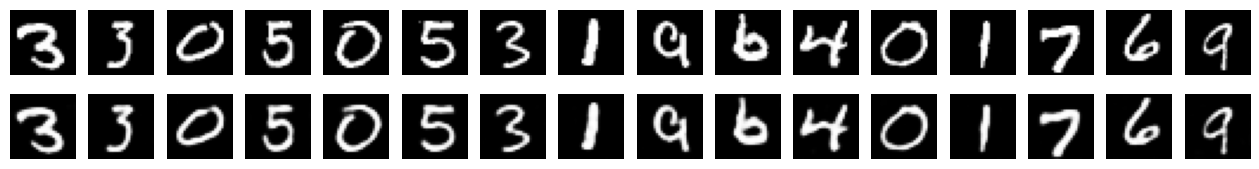

In [24]:
plot_results(outputs, type_lin=False, num_exp=16)

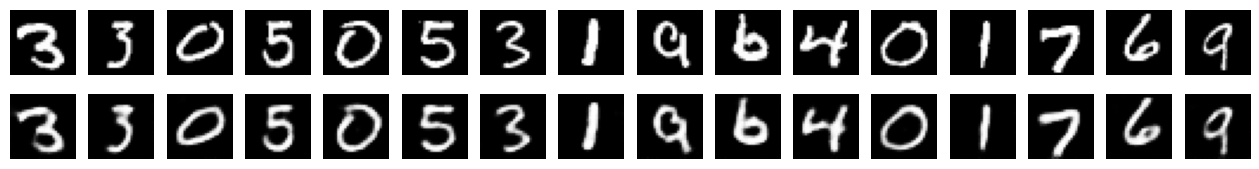

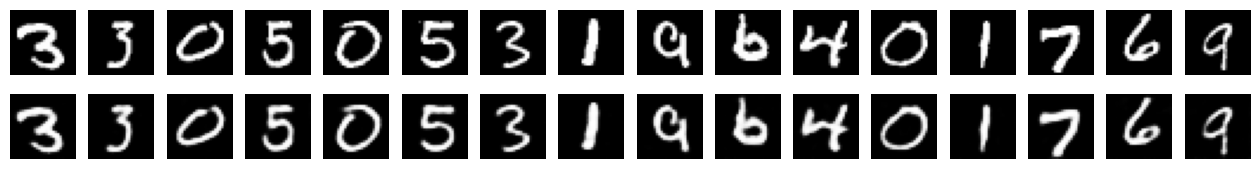

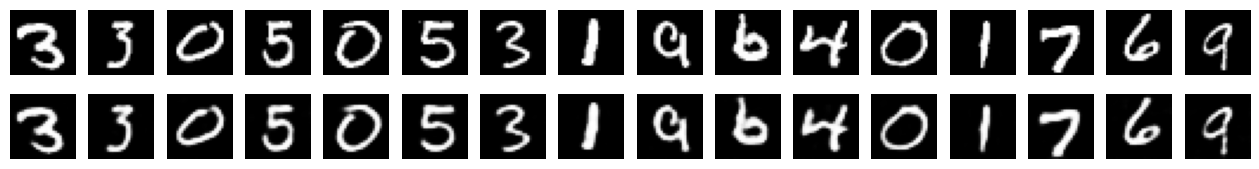

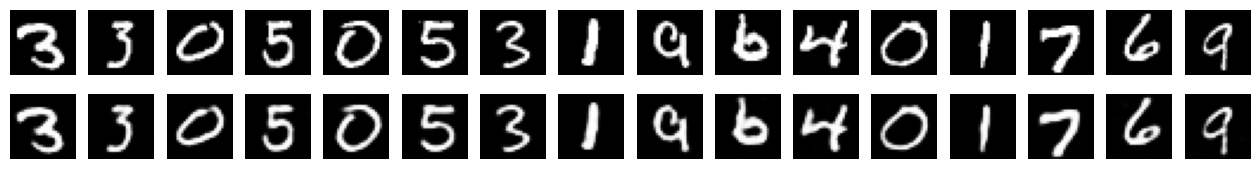

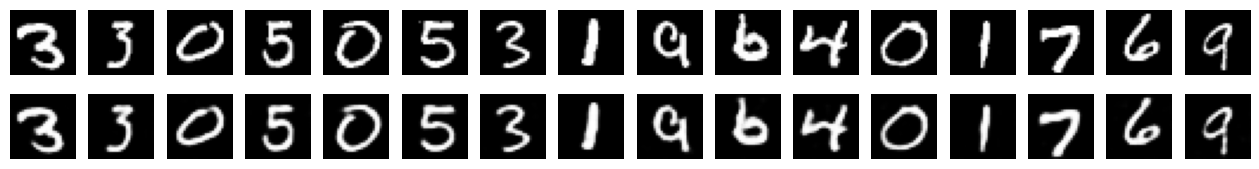

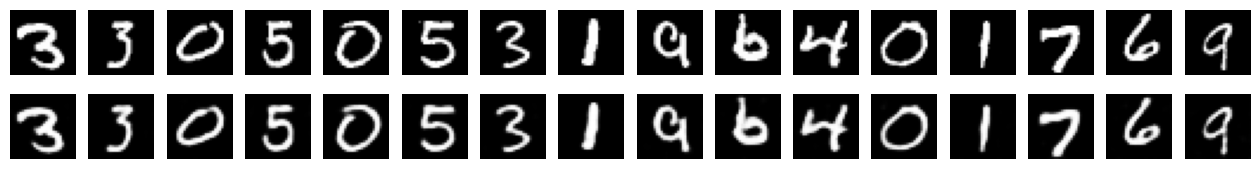

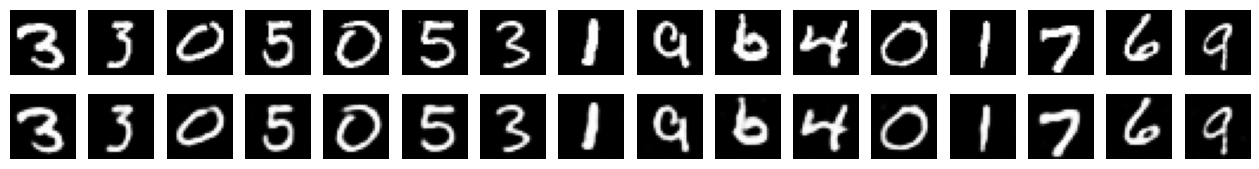

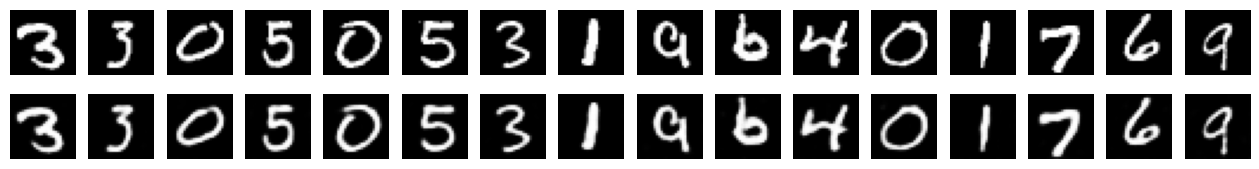

In [31]:
plot_results(outputs, type_lin=False, num_exp=16)

Load weights to encoder

In [68]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("./train_output/20230722-141814/best_model.pth"))

<All keys matched successfully>

In [49]:
autoencoder.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias'])

In [50]:
state_dict_encoder = {}
for key in autoencoder.state_dict().keys():
    if key.startswith('encoder'):
        state_dict_encoder[key] = autoencoder.state_dict()[key]

In [52]:
state_dict_encoder.keys()

dict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias'])

In [48]:
encoder = Encoder()
encoder.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias'])

In [53]:
encoder.load_state_dict(state_dict_encoder)

<All keys matched successfully>

Check the output

In [60]:
images, labels= next(iter(train_loader))
print(images.shape)
one_example = images[0]
one_example.shape

torch.Size([16, 1, 28, 28])


torch.Size([1, 28, 28])

In [63]:
torch.min(one_example)

tensor(0., device='cuda:0')

In [69]:
with torch.no_grad():
    autoencoder.to(device)
    one_example = one_example.to(device)
    output_ae = autoencoder(one_example)
    # print(output_ae)

Encoded value from Autoencoder:tensor([[[-0.7457]],

        [[ 0.5620]],

        [[-0.6241]],

        [[-0.4865]],

        [[-0.5403]],

        [[ 0.2916]],

        [[ 3.2579]],

        [[-3.9441]],

        [[ 2.1407]],

        [[ 1.4270]],

        [[ 1.8823]],

        [[ 0.3147]],

        [[-2.5600]],

        [[-2.5783]],

        [[ 2.1897]],

        [[ 0.5050]],

        [[-1.7919]],

        [[ 1.4605]],

        [[-5.0173]],

        [[-3.6284]],

        [[ 2.3328]],

        [[-2.5260]],

        [[-0.4645]],

        [[-5.0667]],

        [[-1.7970]],

        [[ 0.7015]],

        [[ 5.6178]],

        [[-1.5712]],

        [[ 2.6076]],

        [[ 1.7081]],

        [[ 3.1956]],

        [[-1.5031]],

        [[-0.3090]],

        [[ 1.8911]],

        [[-1.5442]],

        [[ 1.7902]],

        [[ 3.4935]],

        [[ 2.6279]],

        [[ 0.3978]],

        [[-0.7442]],

        [[-2.9619]],

        [[ 3.9502]],

        [[11.8264]],

        [[ 5.5861]],

 

In [66]:
with torch.no_grad():
    encoder.to(device)
    one_example = one_example.to(device)
    output_e = encoder(one_example)
    print(output_e)

tensor([[[-0.7457]],

        [[ 0.5620]],

        [[-0.6241]],

        [[-0.4865]],

        [[-0.5403]],

        [[ 0.2916]],

        [[ 3.2579]],

        [[-3.9441]],

        [[ 2.1407]],

        [[ 1.4270]],

        [[ 1.8823]],

        [[ 0.3147]],

        [[-2.5600]],

        [[-2.5783]],

        [[ 2.1897]],

        [[ 0.5050]],

        [[-1.7919]],

        [[ 1.4605]],

        [[-5.0173]],

        [[-3.6284]],

        [[ 2.3328]],

        [[-2.5260]],

        [[-0.4645]],

        [[-5.0667]],

        [[-1.7970]],

        [[ 0.7015]],

        [[ 5.6178]],

        [[-1.5712]],

        [[ 2.6076]],

        [[ 1.7081]],

        [[ 3.1956]],

        [[-1.5031]],

        [[-0.3090]],

        [[ 1.8911]],

        [[-1.5442]],

        [[ 1.7902]],

        [[ 3.4935]],

        [[ 2.6279]],

        [[ 0.3978]],

        [[-0.7442]],

        [[-2.9619]],

        [[ 3.9502]],

        [[11.8264]],

        [[ 5.5861]],

        [[ 2.8607]],

        [[